<a href="https://colab.research.google.com/github/Ksenia-90/Machine_learning-_in_business/blob/lesson_4/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Урок 4. Uplift-моделирование**##

Домашнее задание
1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [41]:
!pip install scikit-uplift==0.2.0

In [42]:
!pip install catboost

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#df = pd.read_csv("./WA_Fn-UseC_-Telco-Customer-Churn.csv")

df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data.csv")

In [45]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [46]:
df_new = df.rename(columns={'conversion': 'target', 'offer': 'treatment'})

In [47]:
df_new['treatment'].unique()

array(['Buy One Get One', 'No Offer', 'Discount'], dtype=object)

In [48]:
df_new['treatment'] = df_new['treatment'].replace({'Buy One Get One': 1, 'Discount': 1, 'No Offer': 0})
df_new['treatment']

0        1
1        0
2        1
3        1
4        1
        ..
63995    1
63996    1
63997    1
63998    1
63999    1
Name: treatment, Length: 64000, dtype: int64

In [49]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   treatment      64000 non-null  int64  
 8   target         64000 non-null  int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 4.4+ MB


In [50]:
df_new.describe(include=np.object)

,zip_code,channel
count,64000,64000
unique,3,3
top,Surburban,Web
freq,28776,28217


In [51]:
import pandas as pd 

pd.crosstab(df_new.treatment, df_new.target, normalize='index')

target,0,1
treatment,,
0,0.893833,0.106167
1,0.832951,0.167049


In [52]:
df_new['channel'] = df_new['channel'].fillna(value='Не определен')

print(df_new['channel'].value_counts(dropna=False))

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64


In [53]:
df_new['zip_code'] = df_new['zip_code'].fillna(value='Не определен')

print(df_new['zip_code'].value_counts(dropna=False))

Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64


In [54]:
del df_new['zip_code'] 

In [55]:
from sklearn.model_selection import train_test_split

stratify_cols = pd.concat([df_new.treatment, df_new.target], axis=1)

X_train, X_val, treat_train, treant_val, y_train, y_val = train_test_split(
    df_new,
    df_new.treatment,
    df_new.target,
    stratify=stratify_cols,
    test_size=0.3,
    random_state=42
)
cat_features = ['channel']
models_results = {
    'approach': [],
    'uplift@30%': []
}
models_results_20 = {
    'approach': [],
    'uplift@20%': []
}
models_results_10 = {
    'approach': [],
    'uplift@10%': []
}
print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_test.shape}")

Train shape: (44800, 8)
Validation shape: (19200, 8)


In [56]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))

sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

In [57]:
uplift_sm = sm.predict(X_test)

sm_score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treant_val, strategy='by_group', k=0.3)
print(f'uplift@30%: {sm_score:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)


uplift@30%: 0.2033


In [58]:
uplift_sm = sm.predict(X_test)

sm_score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treant_val, strategy='by_group', k=0.2)
sm_score_ = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treant_val, strategy='overall', k=0.2)
print(f'uplift@20%: {sm_score:.4f}')
print(f'Overall_uplift@20%: {sm_score_:.4f}')

models_results_20['approach'].append('SoloModel')
models_results_20['uplift@20%'].append(sm_score)


uplift@20%: 0.3051
Overall_uplift@20%: 0.1293


In [59]:
uplift_sm = sm.predict(X_test)

sm_score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treant_val, strategy='by_group', k=0.1)
sm_score_ = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treant_val, strategy='overall', k=0.1)
print(f'uplift@10%: {sm_score}')
print(f'Overall_uplift@10%: {sm_score_}')

models_results_10['approach'].append('SoloModel')
models_results_10['uplift@10%'].append(sm_score)

uplift@10%: 0.0
Overall_uplift@10%: 0.0


In [60]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

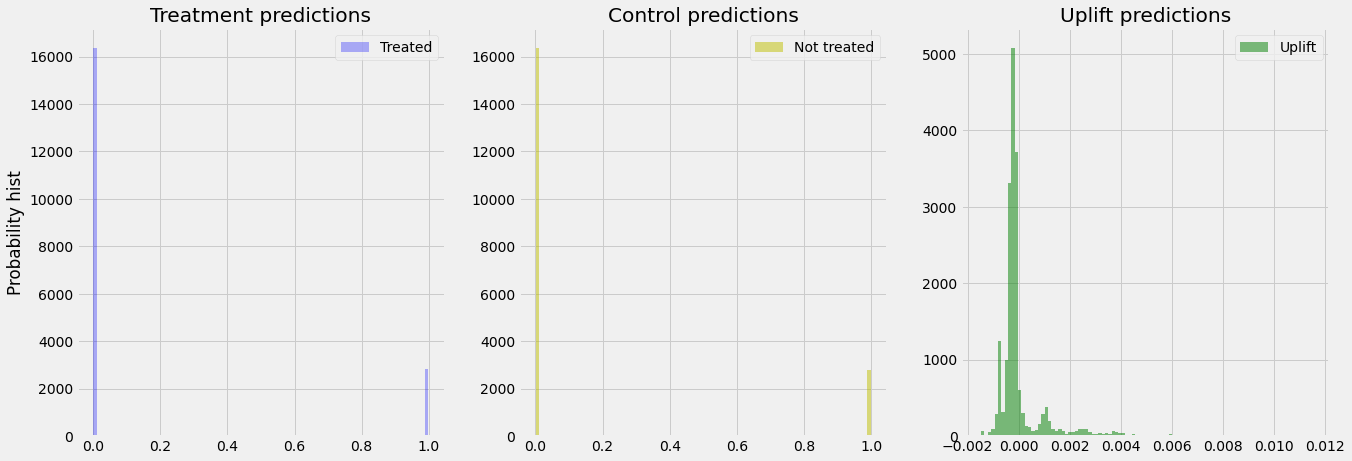

In [61]:
uplift_tm = tm.predict(X_test)

tm_score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treant_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

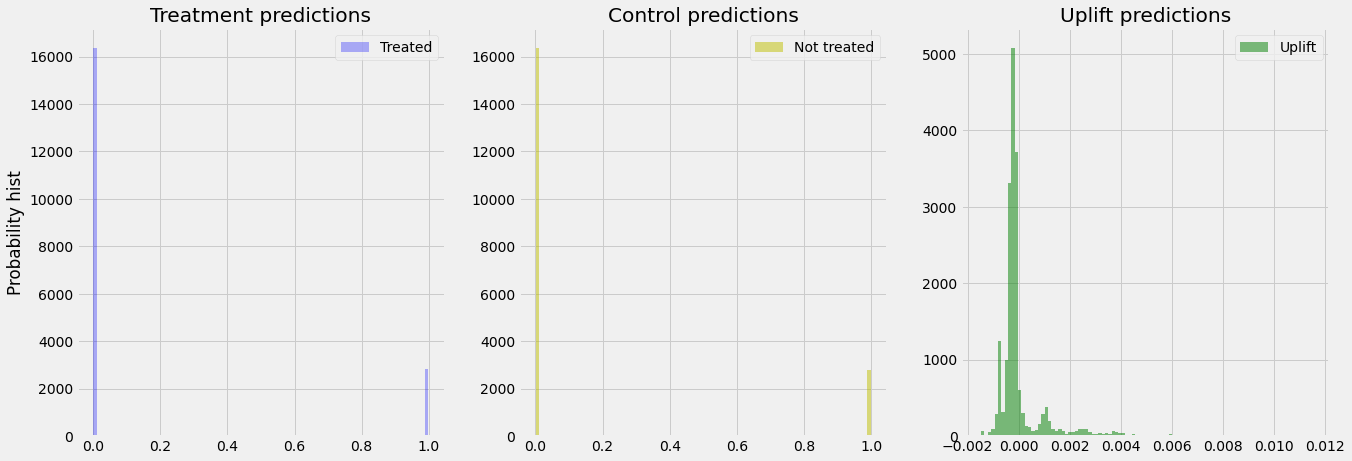

In [62]:
uplift_tm = tm.predict(X_test)

tm_score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treant_test, strategy='by_group', k=0.2)

models_results_20['approach'].append('TwoModels')
models_results_20['uplift@20%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

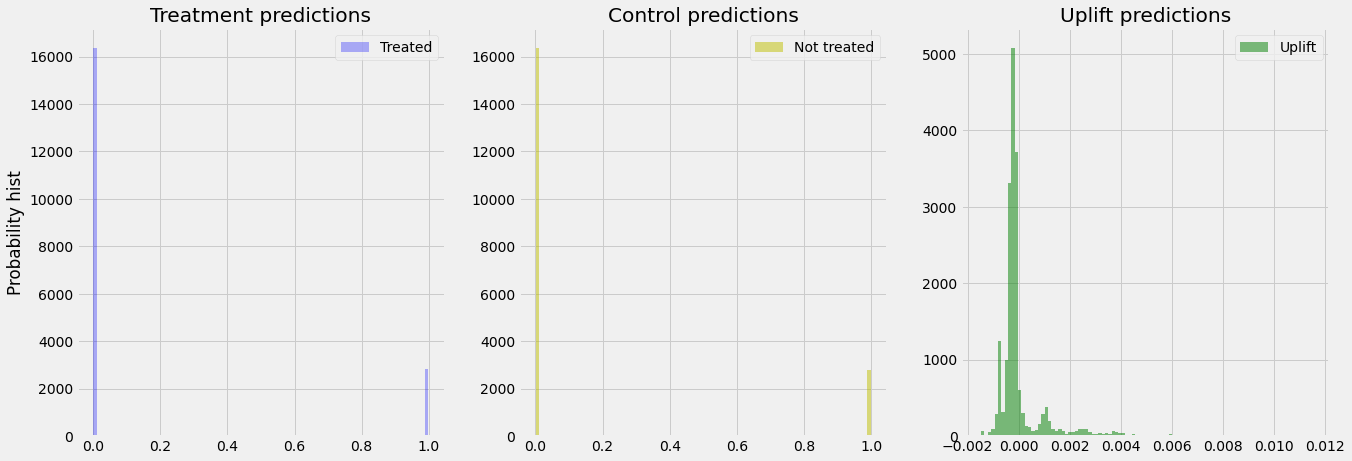

In [63]:
uplift_tm = tm.predict(X_test)

tm_score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treant_test, strategy='by_group', k=0.1)

models_results_10['approach'].append('TwoModels')
models_results_10['uplift@10%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [68]:
!git clone https://github.com/uber/causalml.git
%cd causalml
!pip install -r requirements.txt
!python setup.py build_ext --inplace
!python setup.py install

Cloning into 'causalml'...
remote: Enumerating objects: 2853, done.
remote: Counting objects: 100% (587/587), done.
remote: Compressing objects: 100% (417/417), done.
remote: Total 2853 (delta 339), reused 314 (delta 163), pack-reused 2266
Receiving objects: 100% (2853/2853), 34.49 MiB | 26.67 MiB/s, done.
Resolving deltas: 100% (1764/1764), done.
/content/uplift/causalml/causalml/causalml/causalml/causalml
Compiling causalml/inference/tree/causaltree.pyx because it changed.
Compiling causalml/inference/tree/uplift.pyx because it changed.
[1/2] Cythonizing causalml/inference/tree/causaltree.pyx
/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/uplift/causalml/causalml/causalml/causalml/causalml/causalml/inference/tree/causaltree.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
[2/2] Cythonizing causalml/inference/tree/uplift.pyx
/

In [65]:
X_train_tree = pd.concat([X_train.drop('channel', 1), 
                          pd.get_dummies(X_train['channel'], prefix='channel')], 1)
features = [col for col in X_train_tree]

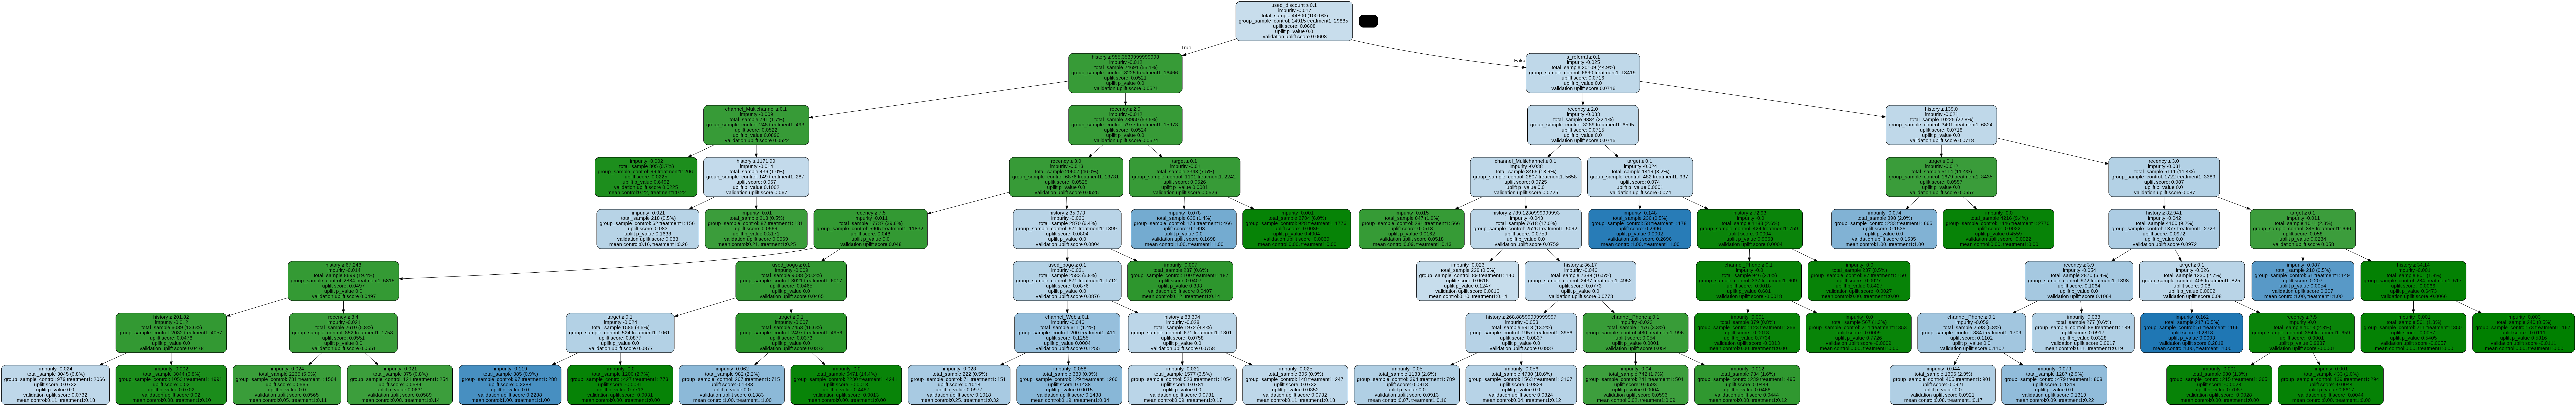

In [70]:
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())